# 调用训练好的 CycleGAN 模型，将照片转为莫奈印象派画风

> 作者：[同济子豪兄](https://space.bilibili.com/1900783)、杨逸飞 2022-4-10

## 进入MMGeneration主目录

In [1]:
import os
os.chdir('mmgeneration')
os.listdir()

['.git',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.pylintrc',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'LICENSES.md',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'apps',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmgen',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmgen.egg-info',
 'outputs',
 'data',
 'checkpoints',
 'work_dirs',
 '.ipynb_checkpoints']

## 命令行方式调用

In [249]:
# 训练得到的最新模型
!python demo/translation_demo.py \
        configs/cyclegan/cyclegan_lsgan_resnet_in_facades_b1x1_80k_monet2photo.py \
        work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/latest.pth \
        --target-domain monet \
        data/zihao-memory/memory1.jpg \
        --save-path outputs/F3_photo2monet_1.jpg \
        --device cuda:0

/environment/miniconda3/lib/python3.7/site-packages/mmcv/cnn/bricks/conv_module.py:151: UserWarning: Unnecessary conv bias before batch/instance norm
  'Unnecessary conv bias before batch/instance norm')
load checkpoint from local path: work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/latest.pth


In [250]:
# 子豪兄训练得到的模型
!python demo/translation_demo.py \
        configs/cyclegan/cyclegan_lsgan_resnet_in_facades_b1x1_80k_monet2photo.py \
        https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220322-mmgeneration/cyclengan_monet2photo_iter_80000.pth \
        data/zihao-memory/memory2.jpg \
        --target-domain monet \
        --save-path outputs/F3_photo2monet_2.jpg \
        --device cuda:0

/environment/miniconda3/lib/python3.7/site-packages/mmcv/cnn/bricks/conv_module.py:151: UserWarning: Unnecessary conv bias before batch/instance norm
  'Unnecessary conv bias before batch/instance norm')
load checkpoint from http path: https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220322-mmgeneration/cyclengan_monet2photo_iter_80000.pth


## Python API 方式调用

### 照片转莫奈印象派画风

#### 导入工具包¶

In [2]:
# 导入mmcv和mmgeneration
# import mmcv
from mmgen.apis import init_model, sample_img2img_model

# 导入 opencv
import cv2

# 导入numpy和matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 载入预训练 CycleGAN 模型（任选一个代码块运行）

注意，`config_file`和`checkpoint_file`需要一一对应。

In [3]:
# 照片转莫奈

# 指定config文件路径
config_file = 'configs/cyclegan/cyclegan_lsgan_resnet_in_facades_b1x1_80k_monet2photo.py'

# 指定预训练模型权重文件路径
checkpoint_file = 'work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/iter_80000.pth'

# 输出图像宽高像素尺寸
img_size = 256

#### 初始化模型

In [4]:
model = init_model(config_file, checkpoint_file, device='cuda:0')

/environment/miniconda3/lib/python3.7/site-packages/mmcv/cnn/bricks/conv_module.py:151: UserWarning: Unnecessary conv bias before batch/instance norm
  'Unnecessary conv bias before batch/instance norm')


load checkpoint from local path: work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/iter_80000.pth


#### 生成并展示图像

In [251]:
# 指定输入图像
input_path = 'data/zihao-memory/memory4.jpg'

# 读入输入图像，获取高宽尺寸
input_img = cv2.imread(input_path)

input_img.shape

(2775, 3883, 3)

In [234]:
# 生成莫奈印象派图像，注意 target_domain 要设置正确
fake_imgs = sample_img2img_model(model, input_path, target_domain='monet')

In [220]:
fake_imgs.shape

torch.Size([1, 3, 256, 256])

In [221]:
# 获取生成图像尺寸
img_size = fake_imgs.shape[2]

In [222]:
img_size

256

In [223]:
# 分别抽取RGB三通道图像，归一化为0-255的uint8自然图像
RGB = np.zeros((img_size, img_size, 3))
RGB[:,:,0] = fake_imgs[0][2]
RGB[:,:,1] = fake_imgs[0][1]
RGB[:,:,2] = fake_imgs[0][0]

In [224]:
RGB.shape

(256, 256, 3)

In [225]:
# 将生成图转为输入图像大小
RGB = cv2.resize(RGB, dsize=(input_img.shape[1],input_img.shape[0]))

In [226]:
RGB.shape

(2775, 3883, 3)

In [227]:
# 像素值归一化
RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
# 像素值转为整数
RGB = RGB.astype('uint8')

In [258]:
# 导出生成的图像文件
cv2.imwrite('outputs/F3_photo2monet.jpg', cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB))

True

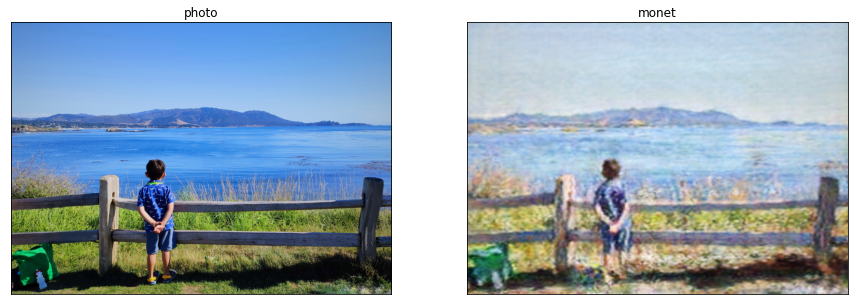

In [231]:
plt.figure(figsize=(15, 15))
# 展示原始输入图像
plt.subplot(1,2,1)
plt.title('photo')
input_RGB = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.xticks([])
plt.yticks([])
plt.imshow(input_RGB)
    
# 展示生成图
plt.subplot(1,2,2)
plt.title('monet')
plt.xticks([])
plt.yticks([])
plt.imshow(RGB)

plt.show()

#### 封装生成图像并可视化的函数

In [5]:
def gen_vis_fake_img(input_path, model, target_domain='monet', figsize=15):
    # 读入输入图像，获取高宽尺寸
    input_img = cv2.imread(input_path)
    # 生成莫奈印象派图像，注意 target_domain 要设置正确
    fake_imgs = sample_img2img_model(model, input_path, target_domain='monet')
    # 获取生成图像尺寸
    img_size = fake_imgs.shape[2]

    # 分别抽取RGB三通道图像，归一化为0-255的uint8自然图像
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = fake_imgs[0][2]
    RGB[:,:,1] = fake_imgs[0][1]
    RGB[:,:,2] = fake_imgs[0][0]
    # 将生成图转为输入图像大小
    RGB = cv2.resize(RGB, dsize=(input_img.shape[1],input_img.shape[0]))
    # 像素值归一化
    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    # 像素值转为整数
    RGB = RGB.astype('uint8')
    # 导出生成的图像文件
    # cv2.imwrite('outputs/F3_out.jpg', cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB))

    plt.figure(figsize=(figsize, figsize))
    # 展示原始输入图像
    plt.subplot(1,2,1)
    plt.title('photo')
    input_RGB = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(input_RGB)

    # 展示生成图
    plt.subplot(1,2,2)
    plt.title('monet')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(RGB)

    plt.show()

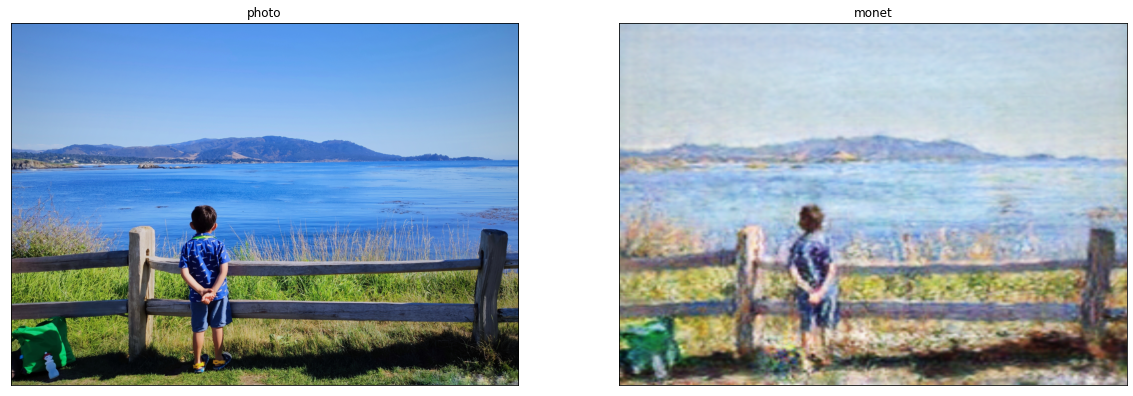

In [6]:
gen_vis_fake_img('data/zihao-memory/memory4.jpg', model, target_domain='monet', figsize=20)

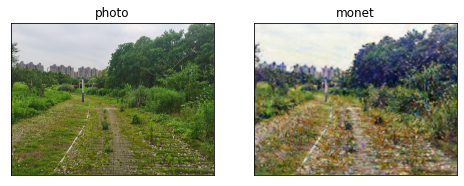

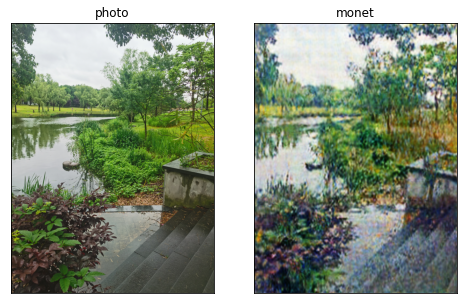

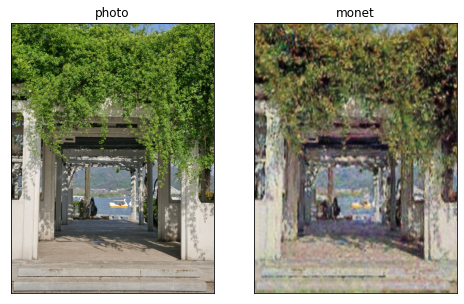

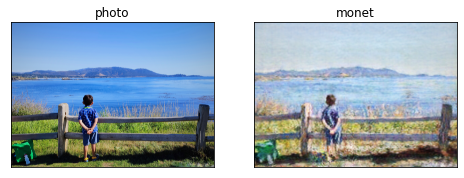

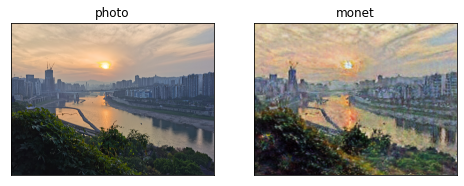

In [7]:
# 对文件夹中的每一张图像运行画作风格迁移
photo_path = 'data/zihao-memory'
os.chdir(photo_path)
for each in os.listdir():
    try:
        gen_vis_fake_img(each, model, target_domain='monet', figsize=8)
    except:
        pass
os.chdir('../../')

In [ ]:
# 对文件夹中的每一张图像运行画作风格迁移
photo_path = 'data/monet2photo/monet2photo/testB'
os.chdir(photo_path)
for each in os.listdir():
    try:
        gen_vis_fake_img(each, model, target_domain='monet', figsize=8)
    except:
        pass
os.chdir('../../')

#### 视频逐帧转莫奈印象派画风

处理单帧的函数

In [8]:
def process_frame(img):
    
    # 临时将本帧图像导出为图片文件
    cv2.imwrite('outputs/F3_temp.jpg', img)
    
    # 生成莫奈印象派图像，注意 target_domain 要设置正确
    fake_imgs = sample_img2img_model(model, 'outputs/F3_temp.jpg', target_domain='monet')
    # 获取生成图像尺寸
    img_size = fake_imgs.shape[2]

    # 分别抽取RGB三通道图像，归一化为0-255的uint8自然图像
    RGB = np.zeros((img_size, img_size, 3))
    RGB[:,:,0] = fake_imgs[0][2]
    RGB[:,:,1] = fake_imgs[0][1]
    RGB[:,:,2] = fake_imgs[0][0]
    # 将生成图转为输入图像大小
    RGB = cv2.resize(RGB, dsize=(img.shape[1], img.shape[0]))
    # 像素值归一化
    RGB = 255 * (RGB - RGB.min()) / (RGB.max()-RGB.min())
    # 像素值转为整数
    RGB = RGB.astype('uint8')
    
    # 蓝绿通道调换
    RGB = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)

    return RGB

视频逐帧处理（代码模板）

In [9]:
# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义 process_frame 函数即可
from tqdm import tqdm

def generate_video(input_path='data/three-hands.mp4', output_path='data/output.mp4'):
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                try:
                    frame = process_frame(frame)
                except Exception as e:
                    print(e)
                    pass
                
                if success == True:
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [10]:
generate_video(input_path='data/zihao-memory/memory-tongji.mp4', output_path='outputs/F3_video.mp4')

视频开始处理 data/zihao-memory/memory-tongji.mp4
视频总帧数为 296


100%|██████████| 295/295 [01:38<00:00,  2.99it/s]

视频已保存 outputs/F3_video.mp4


### 莫奈的画作转照片

将`target_domain`改为`photo`

#### 命令行方式实现

In [13]:
# 训练得到的最新模型
!python demo/translation_demo.py \
        configs/cyclegan/cyclegan_lsgan_resnet_in_facades_b1x1_80k_monet2photo.py \
        work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/latest.pth \
        --target-domain photo \
        'data/monet2photo/monet2photo/testB/2014-08-05 20/38/59.jpg' \
        --save-path outputs/F3_monet2photo_4.jpg \
        --device cuda:0

/environment/miniconda3/lib/python3.7/site-packages/mmcv/cnn/bricks/conv_module.py:151: UserWarning: Unnecessary conv bias before batch/instance norm
  'Unnecessary conv bias before batch/instance norm')
load checkpoint from local path: work_dirs/experiments/cyclegan_monet2photo/ckpt/cyclegan_monet2photo/latest.pth
Traceback (most recent call last):
  File "demo/translation_demo.py", line 60, in <module>
    main()
  File "demo/translation_demo.py", line 51, in main
    **args.sample_cfg)
  File "/home/featurize/work/MMGeneration教程/0409/mmgeneration/mmgen/apis/inference.py", line 213, in sample_img2img_model
    data = test_pipeline(data)
  File "/home/featurize/work/MMGeneration教程/0409/mmgeneration/mmgen/datasets/pipelines/compose.py", line 57, in __call__
    data = t(data)
  File "/home/featurize/work/MMGeneration教程/0409/mmgeneration/mmgen/datasets/pipelines/loading.py", line 58, in __call__
    img_bytes = self.file_client.get(filepath)
  File "/environment/miniconda3/lib/python3.7

#### Python API 方式实现

In [ ]:
gen_vis_fake_img('data/monet2photo/monet2photo/testB/2014-08-05 20/38/59.jpg', model, target_domain='photo', figsize=20)

In [ ]:
# 对文件夹中的每一张图像运行画作风格迁移
photo_path = 'data/monet2photo/monet2photo/testA'
os.chdir(photo_path)
for each in os.listdir():
    try:
        gen_vis_fake_img(each, model, target_domain='photo', figsize=8)
    except:
        pass
os.chdir('../../')

## 课后作业与思考题

1. 莫奈画作转照片 的效果为什么不如 照片转莫奈画作 的效果好？CycleGAN 不应该是对称的吗？

2. 阅读 CycleGAN 原始论文，想想 CycleGAN 还可能有哪些趣味应用场景。

3. 在 CycleGAN 的常用数据集 https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ 中，使用梵高、塞尚、浮世绘等画作转照片的数据集，训练试试看吧~

4. CycleGAN 的预测是实时的，处理每帧画面只需30ms， 接个摄像头，看看效果吧~